### 1. Dataset and Dataloader
### 2. FCN and CNN
### 3. Loss function and Optimizers
### 4. Traning and Evaluation

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
#pytorch 

import torch

import torch.nn as nn # provide modules and classes for implementing neural networks

import torch.optim as optim # provide optimization algorithms

import torch.nn.functional as F # contains all functions of library nn e.g. activation functions

from torch.utils.data import Dataset, DataLoader # creating datasets and dataloaders

from torch.utils.data import random_split # For splitting the dataset into trian, validation and test sets

import torchvision.transforms as transforms  # for visual trnasformation: normalzation, converting into tensors, augmentation
from torchvision import datasets, transforms


### Creating dataset and dataloader

In [4]:
transform = transforms.Compose([transforms.ToTensor()
                              ])

In [5]:
# Creating dataloader

trainset = datasets.ImageFolder('cifar/train', transform=transform)
valset = datasets.ImageFolder('cifar/test', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [6]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 32, 32])
torch.Size([64])


### Creating Dataset using "ImageFolder"

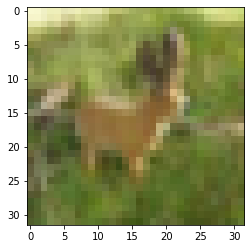

In [7]:
plt.imshow(np.rot90(np.rot90(np.rot90(images[rarandrange(10)].numpy().T))))

In [8]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


## 2: CNN

In [45]:
class CNN(nn.Module):
   
    def __init__(self,input_channel,num_classes):
        super(CNN,self).__init__()
       
        self.conv_model = nn.Sequential(
            
            nn.Conv2d(in_channels=input_channel, out_channels=32, kernel_size=3,padding_mode='replicate',padding=1), # img_size = (inp_img - F + 2P)/S + 1
            # out_img = (64-3)/1 + 1 = 62 (62*62)
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,padding_mode='replicate',padding=1), # img_size = (inp_img - F + 2P)/S + 1
            # out_img = (64-3)/1 + 1 = 62 (62*62)
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # out_img = (62 - 2)/2 + 1 = 31 (31 * 31)
            
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,padding_mode='replicate',padding=1), # img_size = (inp_img - F + 2P)/S + 1
            # out_img = (64-3)/1 + 1 = 62 (62*62)
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding_mode='replicate',padding=1), # img_size = (inp_img - F + 2P)/S + 1
            # out_img = (64-3)/1 + 1 = 62 (62*62)
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # out_img = (62 - 2)/2 + 1 = 31 (31 * 31)
            
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,padding_mode='replicate',padding=1), # img_size = (inp_img - F + 2P)/S + 1
            # out_img = (64-3)/1 + 1 = 62 (62*62)
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,padding_mode='replicate',padding=1), # img_size = (inp_img - F + 2P)/S + 1
            # out_img = (64-3)/1 + 1 = 62 (62*62)
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # out_img = (62 - 2)/2 + 1 = 31 (31 * 31)
            
        )
        
        self.classification_model = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(in_features=2048, out_features=512),   # in_features = 64*6*6 = 2304
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        x = self.conv_model(x)
        # Flattening
        x = x.view(x.size(0), -1) 
        x = self.classification_model(x)
        return x

In [49]:
# Hyperparameters

in_channels = 3 # for CNN

num_classes = 6

lr = 0.002

num_epochs = 20

In [50]:
model = CNN(in_channels, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [51]:
# train CNN network
def train(model, epochs):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(trainloader):
            
            model.train()
            
            # Forward pass
  
            images, labels = images.to(device), labels.to(device)
            x = model(images)
            train_loss = criterion(x, labels)

            # Backward and optimize
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for images, labels in valloader:

              images, labels = images.to(device), labels.to(device)
              x = model(images)     
              valid_loss = criterion(x, labels)

            print (f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

train(model, num_epochs)

Epoch [1/20], Training Loss: 1.2420, Validation Loss: 1.2840
Epoch [2/20], Training Loss: 1.1035, Validation Loss: 0.8825
Epoch [3/20], Training Loss: 0.9851, Validation Loss: 0.9447
Epoch [4/20], Training Loss: 1.2169, Validation Loss: 0.8560
Epoch [5/20], Training Loss: 1.1640, Validation Loss: 0.9831
Epoch [6/20], Training Loss: 1.1193, Validation Loss: 0.7866
Epoch [7/20], Training Loss: 0.9299, Validation Loss: 0.7931
Epoch [8/20], Training Loss: 1.0423, Validation Loss: 0.6318
Epoch [9/20], Training Loss: 0.7719, Validation Loss: 0.7709
Epoch [10/20], Training Loss: 0.7858, Validation Loss: 0.6115
Epoch [11/20], Training Loss: 1.0688, Validation Loss: 0.6557
Epoch [12/20], Training Loss: 0.7785, Validation Loss: 0.6853
Epoch [13/20], Training Loss: 0.7773, Validation Loss: 0.4581
Epoch [14/20], Training Loss: 0.8384, Validation Loss: 0.7373
Epoch [15/20], Training Loss: 0.6170, Validation Loss: 0.7722
Epoch [16/20], Training Loss: 0.6071, Validation Loss: 1.0467
Epoch [17/20], Tr

In [53]:
#CNN model evaluation
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, labels in valloader:
        
        images, labels = images.to(device), labels.to(device)
        prob = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(prob, 1)


        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 74.6 %
